In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary
import torchmetrics

import lightning as L
from lightning.pytorch.loggers import CSVLogger

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# to get deterministic output
torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

c:\Users\Nova\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the Dataset

In [2]:
train_all = datasets.MNIST(root="../datasets/mnist", train=True, transform=transforms.ToTensor(), download=True)
test_ds = datasets.MNIST(root="../datasets/mnist", train=False, transform=transforms.ToTensor())

train_ds, val_ds = random_split(train_all, lengths=[54000, 6000], generator=torch.Generator().manual_seed(42))

print("Train set:", len(train_ds))
print("Val set  :", len(val_ds))
print("Test set :", len(test_ds))

Train set: 54000
Val set  : 6000
Test set : 10000


### Defining the DataLoader

In [3]:
train_loader = DataLoader(dataset=train_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(dataset=val_ds, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(dataset=test_ds, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

In [4]:
train_counter = Counter()
for _, labels in train_loader:
    train_counter.update(labels.tolist())
print("Training label distribution:")
print(sorted(train_counter.items()))
 
val_counter = Counter()
for _, labels in val_loader:
    val_counter.update(labels.tolist())
print("\nValidation label distribution:")
print(sorted(val_counter.items()))
    
test_counter = Counter()
for _, labels in test_loader:
    test_counter.update(labels.tolist())
print("\nTest label distribution:")
print(sorted(test_counter.items()))

Training label distribution:
[(0, 5340), (1, 6076), (2, 5383), (3, 5509), (4, 5246), (5, 4903), (6, 5308), (7, 5609), (8, 5254), (9, 5372)]

Validation label distribution:
[(0, 583), (1, 666), (2, 575), (3, 622), (4, 596), (5, 518), (6, 610), (7, 656), (8, 597), (9, 577)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


### Visualize the Dataset

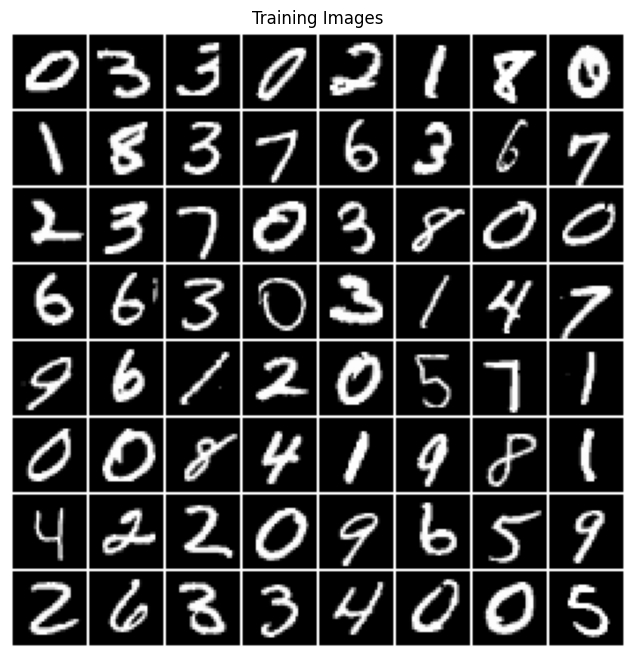

In [5]:
for images, _ in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(
    images[:64], 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)
))
plt.show()

### Zero-Rule baseline (Majority class classifier)

In [6]:
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print(f"Accuracy when always predicting the majority class: {baseline_acc:.2f}")

Majority class: 1
Accuracy when always predicting the majority class: 0.11


### Design the Model

In [7]:
class PyTorchMLP(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(
            # 1st hidden layer
            nn.Linear(num_features, 50),
            nn.ReLU(),
            
            # 2nd hidden layer
            nn.Linear(50, 25),
            nn.ReLU(),
            
            # output layer
            nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits
    
    def predict(self, x):
        self = self.eval()
        with torch.inference_mode():
            return self(x)
        
pytorch_model = PyTorchMLP(num_features=784, num_classes=10)
summary(pytorch_model)

Layer (type:depth-idx)                   Param #
PyTorchMLP                               --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       39,250
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       1,275
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       260
Total params: 40,785
Trainable params: 40,785
Non-trainable params: 0

In [8]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.lr = learning_rate
        self.model = model
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)
    
    def common_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)
        pred_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, pred_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, pred_labels = self.common_step(batch)        
        self.train_acc(pred_labels, true_labels)
        self.log("train_loss", loss)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, pred_labels = self.common_step(batch)        
        self.val_acc(pred_labels, true_labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        loss, true_labels, pred_labels = self.common_step(batch)
        self.test_acc(pred_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer
    
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)
summary(lightning_model)

Layer (type:depth-idx)                   Param #
LightningModel                           --
├─PyTorchMLP: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  39,250
│    │    └─ReLU: 3-2                    --
│    │    └─Linear: 3-3                  1,275
│    │    └─ReLU: 3-4                    --
│    │    └─Linear: 3-5                  260
├─MulticlassAccuracy: 1-2                --
├─MulticlassAccuracy: 1-3                --
├─MulticlassAccuracy: 1-4                --
Total params: 40,785
Trainable params: 40,785
Non-trainable params: 0

### Train the Model

In [9]:
trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="05_LightningMLP_mnist"),
    deterministic=False,
)

trainer.fit(model=lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | PyTorchMLP         | 40.8 K | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 844/844 [00:11<00:00, 72.46it/s, v_num=4, val_loss=0.133, val_acc=0.963, train_acc=0.972]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 844/844 [00:11<00:00, 72.38it/s, v_num=4, val_loss=0.133, val_acc=0.963, train_acc=0.972]


### Save and Load the Checkpoint

In [10]:
# save the checkpoint
# CP_PATH = "model.ckpt"
# trainer.save_checkpoint(CP_PATH)

# load the checkpoint
# pytorch_model = PyTorchMLP(num_features=784, num_classes=10)
# lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=CP_PATH, model=pytorch_model)

### Evaluate the Model

In [11]:
train_acc = trainer.validate(dataloaders=train_loader)[0]["val_acc"]
val_acc = trainer.validate(dataloaders=val_loader)[0]["val_acc"]
test_acc = trainer.test(dataloaders=test_loader)[0]["test_acc"]

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Val Accuracy  : {val_acc:.2f}")
print(f"Test Accuracy : {test_acc:.2f}")

c:\Users\Nova\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:149: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/05_LightningMLP_mnist\version_4\checkpoints\epoch=9-step=8440.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/05_LightningMLP_mnist\version_4\checkpoints\epoch=9-step=8440.ckpt
c:\Users\Nova\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:484: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation DataLoader 0: 100%|██████████| 844/844 [00:07<00:00, 117.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9737963080406189     │
│         val_loss          │     0.08807323127985      │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/05_LightningMLP_mnist\version_4\checkpoints\epoch=9-step=8440.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/05_LightningMLP_mnist\version_4\checkpoints\epoch=9-step=8440.ckpt


Validation DataLoader 0: 100%|██████████| 94/94 [00:01<00:00, 89.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9626666903495789     │
│         val_loss          │    0.13255389034748077    │
└───────────────────────────┴───────────────────────────┘

c:\Users\Nova\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/05_LightningMLP_mnist\version_4\checkpoints\epoch=9-step=8440.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/05_LightningMLP_mnist\version_4\checkpoints\epoch=9-step=8440.ckpt


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 127.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9641000032424927     │
└───────────────────────────┴───────────────────────────┘

Train Accuracy: 0.97
Val Accuracy  : 0.96
Test Accuracy : 0.96


### Make Prediction

In [12]:
X_tests = []
y_trues = []
y_preds = []

for x_batch, y_batch in test_loader:
    probas = pytorch_model.predict(x_batch)
    preds = np.argmax(probas, axis=1)
    X_tests.append(x_batch)
    y_trues.append(y_batch)
    y_preds.append(preds)
    
X_tests = torch.cat(X_tests, dim=0)
y_trues = torch.cat(y_trues, dim=0)
y_preds = torch.cat(y_preds, dim=0)

# remove the color dimention
X_tests = X_tests.squeeze(1)

correct_indices = []
incorrect_indices = []
for i in range(len(y_preds)):
    if y_preds[i] == y_trues[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

### Visualize Confusion Matrix

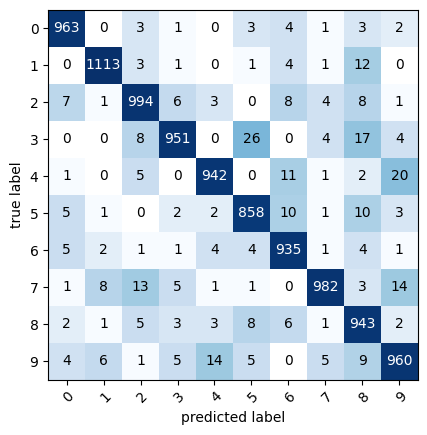

In [13]:
import matplotlib
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

class_dict = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9'}
cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict))

for x, y in test_loader:
    with torch.inference_mode():
        pred = lightning_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat_str = cmat_tensor.numpy()
fig, ax = plot_confusion_matrix(
    conf_mat=cmat_str,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

### Visualize Training Metrices

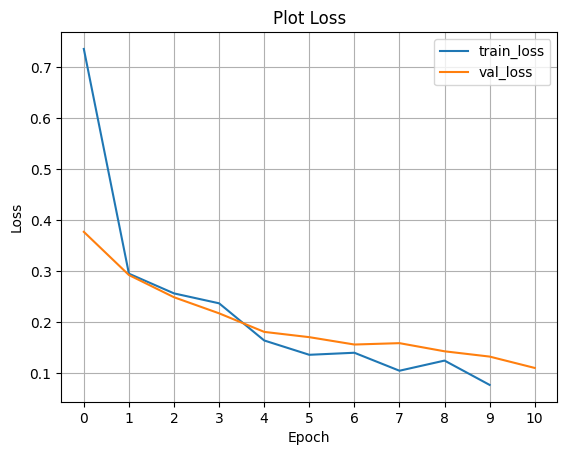

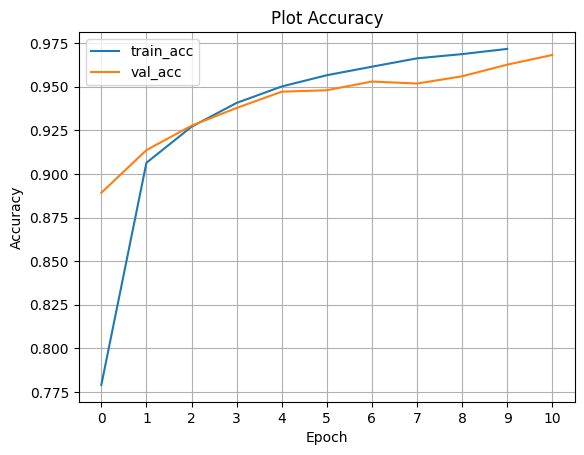

In [14]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

agg_col = "epoch"
aggreg_metrics = []
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

num_epochs = len(aggreg_metrics)
df_metrics = pd.DataFrame(aggreg_metrics)
xtics = np.arange(0, num_epochs, 1)
df_metrics[["train_loss", "val_loss"]].plot(title="Plot Loss", xlabel="Epoch", ylabel="Loss", xticks=xtics, grid=True, legend=True)
df_metrics[["train_acc", "val_acc"]].plot(title="Plot Accuracy", xlabel="Epoch", ylabel="Accuracy", xticks=xtics, grid=True, legend=True)
plt.show()

### Visualize the Prediction

Correct Predictions: 9641


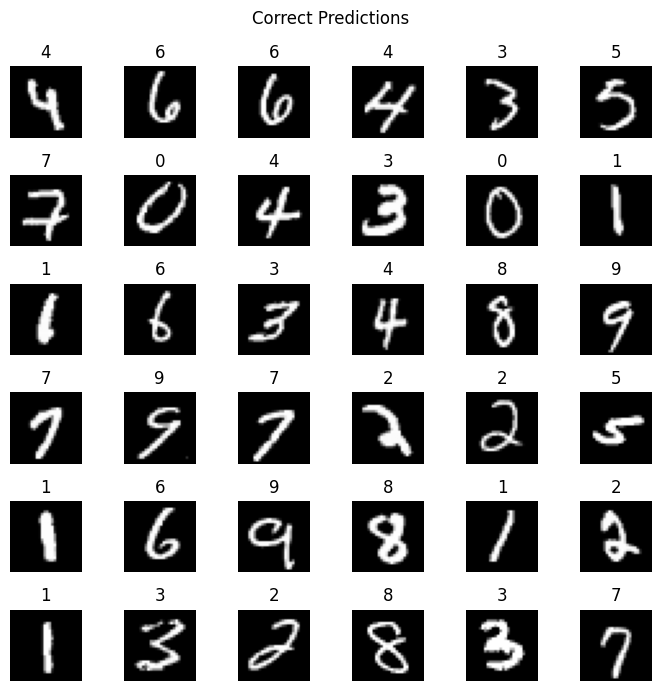

In [15]:
print("Correct Predictions:", len(correct_indices))

plt.figure(figsize=(7,7))
for i in range(36):
    idx = random.choice(correct_indices)
    plt.subplot(6,6,i+1)
    plt.imshow(X_tests[idx], cmap='gray')
    plt.axis('off')
    plt.title(f"{y_preds[idx]}")
plt.suptitle("Correct Predictions")
plt.tight_layout()
plt.show()

Incorrect Predictions: 359


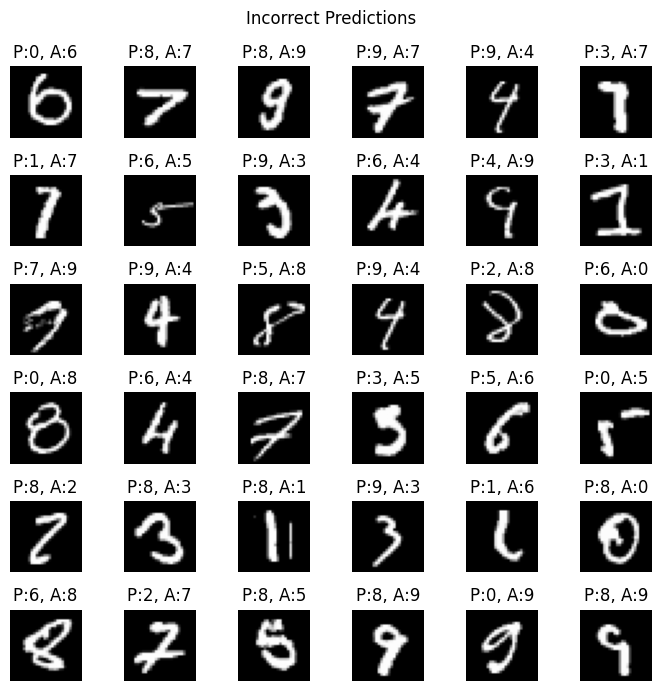

In [16]:
print("Incorrect Predictions:", len(incorrect_indices))

plt.figure(figsize=(7,7))
for i in range(36):
    idx = random.choice(incorrect_indices)
    plt.subplot(6,6,i+1)
    plt.imshow(X_tests[idx], cmap='gray')
    plt.axis('off')
    plt.title(f"P:{y_preds[idx]}, A:{y_trues[idx]}")
plt.suptitle("Incorrect Predictions")
plt.tight_layout()
plt.show()